## Winding layout procedure

In [74]:
def swap(a,b):
    return b,a

In [75]:
import numpy as np
import pandas as pd
slot = 12
pole = 4
phase = 3
coil_pitch = max(int(slot/pole),1)
print('coil_pitch:',coil_pitch)
theta_m = 360/slot
theta_e = pole/2*theta_m
S_ = max(int(slot/pole),1)
slot_in = np.arange(1,slot+1)
slot_out = np.concatenate((slot_in[S_:],slot_in[:S_]))
angle = np.arange(slot)*theta_e
# turn angle to -180~180
angle180 = np.array([])
for i in angle:
    if i > 180:
        i%=360
    if i>180:
        i = i-360
    angle180 = np.append(angle180,i)
# turn angle to -90~90
angle90 = np.array([])
for i in range(len(angle180)):
    if angle180[i] > 90:
        angle180[i] = angle180[i]-180
        slot_in[i],slot_out[i] = swap(slot_in[i],slot_out[i])
    if angle180[i] < -90:
        angle180[i] = angle180[i]+180
        slot_in[i],slot_out[i] = swap(slot_in[i],slot_out[i])
    angle90 = np.append(angle90,angle180[i])
print(angle90)
# find the angle is close to 0 is phase A
# find the angle is close to 120(-60) is phase B
# find the angle is close to 240(-120) is phase C
phaseA = np.array([])
phaseB = np.array([])
phaseC = np.array([])
for i in range(len(angle90)):
    ## phase A
    if -30<=angle90[i]<30:
        phaseA = np.append(phaseA,i)
    ## phase B
    elif angle90[i]<=-60 :
        phaseB = np.append(phaseB,i)
        angle90[i] = angle90[i]+180
        slot_in[i],slot_out[i] = swap(slot_in[i],slot_out[i])
    elif 60<angle90[i]<=120:
        phaseB = np.append(phaseB,i)
    ## phase C
    elif 30<=angle90[i]<=60:
        phaseC = np.append(phaseC,i)
        angle90[i] = angle90[i]+180
        slot_in[i],slot_out[i] = swap(slot_in[i],slot_out[i])
    else:
        phaseC = np.append(phaseC,i)
        angle90[i] = angle90[i]+180
        slot_in[i],slot_out[i] = swap(slot_in[i],slot_out[i])

#print('phaseA:',phaseA)
#print('phaseB:',phaseB)
#print('phaseC:',phaseC)
#print('angle',angle90)


coil_pitch: 3
[  0.  60. -60.   0.  60. -60.   0.  60. -60.   0.  60. -60.]


In [76]:
## create a dataframe to show the result
phase_a = np.zeros(slot)
phase_b = np.zeros(slot)
phase_c = np.zeros(slot)
for i in range(len(phaseA)):
    phase_a[int(phaseA[i])] = 1
    phase_b[int(phaseB[i])] = 1
    phase_c[int(phaseC[i])] = 1
#print('phase_a:',phase_a)
#print('phase_b:',phase_b)
#print('phase_c:',phase_c)
data = {'slot_in':slot_in,'slot_out':slot_out,'angle':angle90,'phase_a':phase_a,'phase_b':phase_b,'phase_c':phase_c}
df = pd.DataFrame(data)
## visualize the result
#TODO
df


,slot_in,slot_out,angle,phase_a,phase_b,phase_c
0,1,4,0.0,1.0,0.0,0.0
1,5,2,240.0,0.0,0.0,1.0
2,3,6,120.0,0.0,1.0,0.0
3,7,4,0.0,1.0,0.0,0.0
4,5,8,240.0,0.0,0.0,1.0
5,9,6,120.0,0.0,1.0,0.0
6,7,10,0.0,1.0,0.0,0.0
7,11,8,240.0,0.0,0.0,1.0
8,9,12,120.0,0.0,1.0,0.0
9,1,10,0.0,1.0,0.0,0.0


In [77]:
# create IO table
slot_num = np.arange(1,slot+1)
#print('slot_in',slot_in)
#print('slot_out',slot_out)
#print('phase_a:',phase_a)
#print('phase_b:',phase_b)
#print('phase_c:',phase_c)
phase_A = np.zeros(slot)
phase_B = np.zeros(slot)
phase_C = np.zeros(slot)
## 1->IN, -1->OUT, 0->NULL, 2->IN&IN, -2->OUT&OUT
IO_table = pd.DataFrame({'A':phase_A,'B':phase_B,'C':phase_C})
IO_table.index+=1
for i in range(slot):
    if phase_a[i] == 1:
        IN = slot_in[i]
        OUT = slot_out[i]
        IO_table.loc[IN,'A'] += 1
        IO_table.loc[OUT,'A'] -= 1
    if phase_b[i] == 1:
        IN = slot_in[i]
        OUT = slot_out[i]
        IO_table.loc[IN,'B'] += 1
        IO_table.loc[OUT,'B'] -= 1
    if phase_c[i] == 1:
        IN = slot_in[i]
        OUT = slot_out[i]
        IO_table.loc[IN,'C'] += 1
        IO_table.loc[OUT,'C'] -= 1
IO_table

,A,B,C
1,2.0,0.0,0.0
2,0.0,0.0,-2.0
3,0.0,2.0,0.0
4,-2.0,0.0,0.0
5,0.0,0.0,2.0
6,0.0,-2.0,0.0
7,2.0,0.0,0.0
8,0.0,0.0,-2.0
9,0.0,2.0,0.0
10,-2.0,0.0,0.0


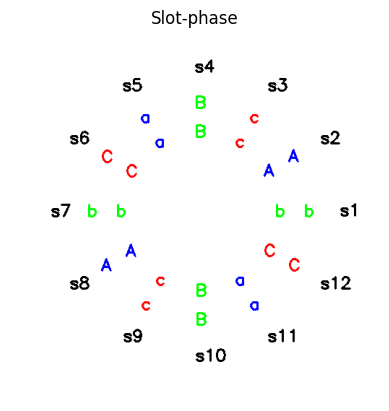

In [78]:
## to be visualized
import matplotlib.pyplot as plt
import cv2
img = np.ones((512,512,3), np.uint8)*255 ## create a white image
center = (img.shape[0]//2,img.shape[1]//2)
color = {'A':(0,0,255),'B':(0,255,0),'C':(255,0,0)}

def polar_draw(r,theta,text,center,c):
    x = int(r*np.cos(theta)+center[0])
    y = int(r*np.sin(theta)+center[1])
    #cv2.line(img,center,(x,y),(255,0,0),2)
    cv2.putText(img,text,(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.75,c,2)
    return x,y
## draw the slot
angle = 360/slot
for i in range(slot):
    r = 200
    theta = (360 - angle*i)*np.pi/180#-angle//2*np.pi/180
    x,y = polar_draw(r,theta,"s"+str(i+1),center,(0,0,0))
## draw the phase
r = 150
p = ['A','B','C']
for i in range(1,len(df)+1):
    shift = 0
    for j in p:
        if IO_table.loc[i,j] == 1:
            theta = (360 - angle*i)*np.pi/180
            x,y = polar_draw(r,theta,str(j),center,color[j])
        if IO_table.loc[i,j] == -1:
            theta = (360 - angle*i)*np.pi/180
            x,y = polar_draw(r-40,theta,str(j.lower()),center,color[j])
        if IO_table.loc[i,j] == 2:
            theta = (360 - angle*i)*np.pi/180
            x,y = polar_draw(r,theta,str(j),center,color[j])
            x,y = polar_draw(r-40,theta,str(j),center,color[j])
        if IO_table.loc[i,j] == -2:
            theta = (360 - angle*i)*np.pi/180
            x,y = polar_draw(r,theta,str(j.lower()),center,color[j])
            x,y = polar_draw(r-40,theta,str(j.lower()),center,color[j])
plt.title('Slot-phase')
plt.axis('off')
plt.imshow(img)

In [79]:
def coil_phase(nuten, pole):
    if nuten % 3 != 0 or nuten < 3:
        return "槽數必須是3的倍數!"  # 槽數必須是3的倍數

    if pole % 2 != 0 or pole < 2:
        return "極數必須是偶數!"  # 極數必須是偶數

    if pole == nuten:
        return "極數不能等於槽數!"  # 極數不能等於槽數

    winkel = 180 * pole / nuten
    summe = 0
    schema = ""
    summe_l = []
    # 繞組分配
    for i in range(nuten):
        # A 最接近 0° 或 360°
        # B 最接近 120°
        # C 最接近 240°
        if summe >= 330 or summe < 30:
            schema += "A"
            summe_l.append(summe)
        elif summe >= 90 and summe < 150:
            schema += "B"
            summe_l.append(summe)
        elif summe >= 210 and summe < 270:
            schema += "C"
            summe_l.append(summe)
        
        elif summe >= 150 and summe < 210:
            schema += "a"
            summe_l.append(summe-180)
        elif summe >= 270 and summe < 330:
            schema += "b"
            summe_l.append(summe-180)
        elif summe >= 30 and summe < 90:
            schema += "c"
            summe_l.append(summe-180)
        summe = (summe + winkel) % 360
    #print(summe_l)

    # 驗證繞組平衡性
    a_count = schema.count("a")
    b_count = schema.count("b")
    c_count = schema.count("c")
    A_count = schema.count("A")
    B_count = schema.count("B")
    C_count = schema.count("C")

    if a_count == b_count == c_count and A_count == B_count == C_count:
        return schema
    else:
        return f"不平衡! ({schema})"

AcBaCbAcBaCb


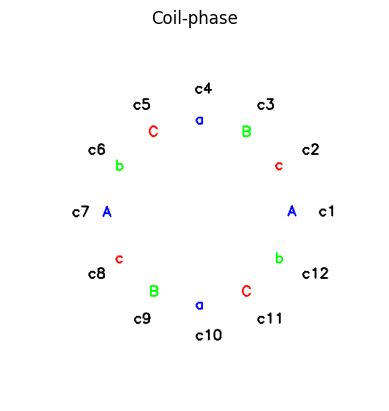

In [80]:
## visualize the coil phase
coil_phase_ = coil_phase(slot,pole)
print(coil_phase_)
img = np.ones((600,600,3), np.uint8)*255 ## create a white image
center = (img.shape[0]//2,img.shape[1]//2)
color = {'A':(0,0,255),'B':(0,255,0),'C':(255,0,0),'a':(0,0,255),'b':(0,255,0),'c':(255,0,0)}
angle = 360/slot
for i in range(slot):
    polar_draw(200,(360 - angle*i)*np.pi/180,"c"+str(i+1),center,(0,0,0))
for i in range(slot):
    r = 150
    theta = (360 - angle*i)*np.pi/180
    x,y = polar_draw(r,theta,coil_phase_[i],center,color[coil_phase_[i]])
plt.title('Coil-phase')
plt.axis('off')
plt.imshow(img)

AcBaCbAcBaCb


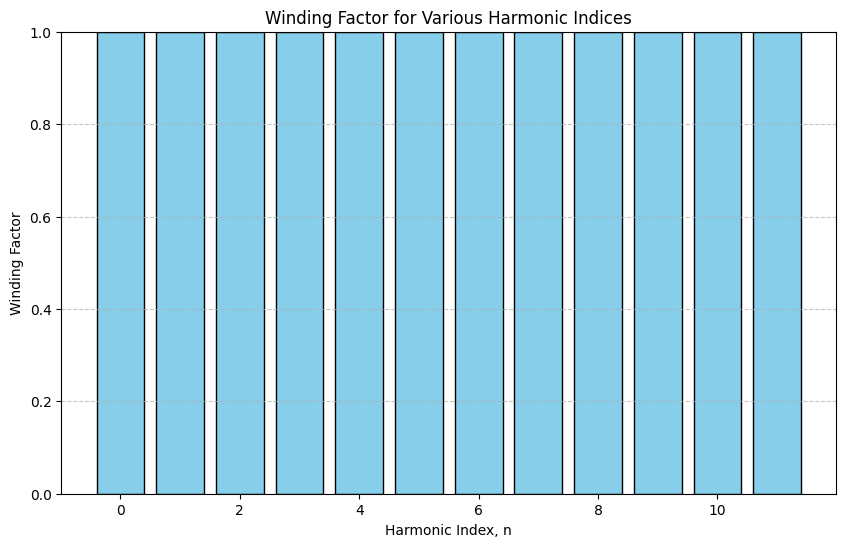

In [81]:
## plot the winding factor
import matplotlib.pyplot as plt
N_cph = slot//3
result = coil_phase(slot, pole)
print(result)
K_wn_list = []
angle = angle90
for n in range(12):
    K_wn = 0 
    for k in range(N_cph):
        if result[k] == 'A' or result[k]=='a':
            theta_k = angle[k]
        elif result[k] == 'B' or result[k]=='b':
            theta_k =  angle[k] -120
        elif result[k] == 'C' or result[k]=='c':
            theta_k =  angle[k] -240
        K_wn += np.cos(np.deg2rad(n*theta_k))
    K_wn_list.append(abs(K_wn/N_cph))


plt.figure(figsize=(10, 6))
plt.bar(range(12),K_wn_list, color='skyblue', edgecolor='black')
plt.xlabel('Harmonic Index, n')
plt.ylabel('Winding Factor')
plt.title('Winding Factor for Various Harmonic Indices')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## pitch factor & distribution factor

In [82]:
def get_Kd(n,slot,pole):
    m = slot/pole/3
    alpha = 180/m/3
    Kd = np.sin(n*m*alpha/2)/(m*np.sin(n*alpha/2))
    return Kd
Kd = get_Kd(1,slot,pole)

P = slot/pole
Kp = np.sin(P*90)

## 6.7 inductance revisited

In [83]:
Sk = [1,1,1,0,-1,-1,-1,1,2,2,1,-1,-1,-1,0]
def sign(x):
    if x>0:
        return 1
    elif x<0:
        return -1
    else:
        return 0
def get_Lg(Sk):
    sigma = 0
    sum_Sk = sum(Sk)
    for i in range(len(Sk)):
        sigma += sign(Sk[i])*(Sk[i]-sum_Sk/len(Sk))
    return sigma
Lg = get_Lg(Sk)
Lg

14.8

In [84]:
df

,slot_in,slot_out,angle,phase_a,phase_b,phase_c
0,1,4,0.0,1.0,0.0,0.0
1,5,2,240.0,0.0,0.0,1.0
2,3,6,120.0,0.0,1.0,0.0
3,7,4,0.0,1.0,0.0,0.0
4,5,8,240.0,0.0,0.0,1.0
5,9,6,120.0,0.0,1.0,0.0
6,7,10,0.0,1.0,0.0,0.0
7,11,8,240.0,0.0,0.0,1.0
8,9,12,120.0,0.0,1.0,0.0
9,1,10,0.0,1.0,0.0,0.0


In [85]:
## for phase A
#phase_a
df_A = df[df['phase_a']==1]
df_A = df_A[['slot_in','slot_out','phase_a']]
Sk = np.zeros(slot)
for i in range(len(df_A)):
    from_ = int(df_A.iloc[i]['slot_in'])
    to_ = int(df_A.iloc[i]['slot_out'])
    print('from',from_)
    print('to',to_)
    if from_ > to_:
        Sk[to_-1:from_] -=1
    elif from_ < to_:
        Sk[from_-1:to_] +=1
    print(Sk)


from 1
to 4
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
from 7
to 4
[ 1.  1.  1.  0. -1. -1. -1.  0.  0.  0.  0.  0.]
from 7
to 10
[ 1.  1.  1.  0. -1. -1.  0.  1.  1.  1.  0.  0.]
from 1
to 10
[2. 2. 2. 1. 0. 0. 1. 2. 2. 2. 0. 0.]
